<h1>NN module PyTorch<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Группировка-входных-данных-в-батчи" data-toc-modified-id="Группировка-входных-данных-в-батчи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Группировка входных данных в батчи</a></span></li><li><span><a href="#Оптимизация-по-батчам" data-toc-modified-id="Оптимизация-по-батчам-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оптимизация по батчам</a></span></li><li><span><a href="#Замена-линейной-модели" data-toc-modified-id="Замена-линейной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Замена линейной модели</a></span></li><li><span><a href="#Информация-о-параметрах" data-toc-modified-id="Информация-о-параметрах-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Информация о параметрах</a></span></li><li><span><a href="#Сравнение-с-линейной-моделью" data-toc-modified-id="Сравнение-с-линейной-моделью-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение с линейной моделью</a></span></li><li><span><a href="#Упражнения" data-toc-modified-id="Упражнения-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Упражнения</a></span></li></ul></div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from collections import OrderedDict
from matplotlib import pyplot as plt

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, 4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1)
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

### Линейная модель

In [3]:
linear_model = nn.Linear(1, 1)

In [4]:
linear_model(t_un_val)

tensor([[0.5916],
        [0.5355]], grad_fn=<AddmmBackward0>)

In [5]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.0415]], requires_grad=True),
 Parameter containing:
 tensor([0.2516], requires_grad=True))

In [6]:
x = torch.ones(1)
linear_model(x)

tensor([0.2931], grad_fn=<ViewBackward0>)

### Группировка входных данных в батчи

In [7]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931],
        [0.2931]], grad_fn=<AddmmBackward0>)

### Оптимизация по батчам

In [8]:
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-4
)

In [9]:
linear_model.parameters()

<generator object Module.parameters at 0x12d7e4c80>

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.0415]], requires_grad=True),
 Parameter containing:
 tensor([0.2516], requires_grad=True)]

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
              t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f},'
                  f'Validation loss {loss_val.item():.4f}')

In [12]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [13]:
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 85.3100,Validation loss 585.0079
Epoch 500, Training loss 11.4322,Validation loss 145.6837
Epoch 1000, Training loss 10.7974,Validation loss 120.4607
Epoch 1500, Training loss 10.7382,Validation loss 117.8203
Epoch 2000, Training loss 10.6842,Validation loss 117.0610
Epoch 2500, Training loss 10.6310,Validation loss 116.4712
Epoch 3000, Training loss 10.5784,Validation loss 115.9008

Parameter containing:
tensor([[1.8213]], requires_grad=True)
Parameter containing:
tensor([0.2898], requires_grad=True)


### Замена линейной модели

In [14]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

In [15]:
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

### Информация о параметрах

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

In [19]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1727], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

In [23]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 100.1883,Validation loss 636.9100
Epoch 500, Training loss 11.0387,Validation loss 183.7402
Epoch 1000, Training loss 7.5406,Validation loss 128.3131
Epoch 1500, Training loss 6.3494,Validation loss 102.6777
Epoch 2000, Training loss 5.5554,Validation loss 87.3707
Epoch 2500, Training loss 4.9105,Validation loss 76.5922
Epoch 3000, Training loss 4.3814,Validation loss 68.6407
Epoch 3500, Training loss 3.9541,Validation loss 62.8994
Epoch 4000, Training loss 3.6127,Validation loss 59.1122
Epoch 4500, Training loss 3.3396,Validation loss 57.1956
Epoch 5000, Training loss 3.1183,Validation loss 57.1420


In [24]:
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

output tensor([[18.2899],
        [16.5277]], grad_fn=<AddmmBackward0>)
answer tensor([[28.],
        [21.]])
hidden tensor([[ 0.0430],
        [-0.0477],
        [-0.0415],
        [-0.0580],
        [-0.0556],
        [-0.0552],
        [ 0.0598],
        [-0.0533]])


### Сравнение с линейной моделью

In [25]:
t_range = torch.arange(20., 90.).unsqueeze(1)

In [26]:
t_range.shape

torch.Size([70, 1])

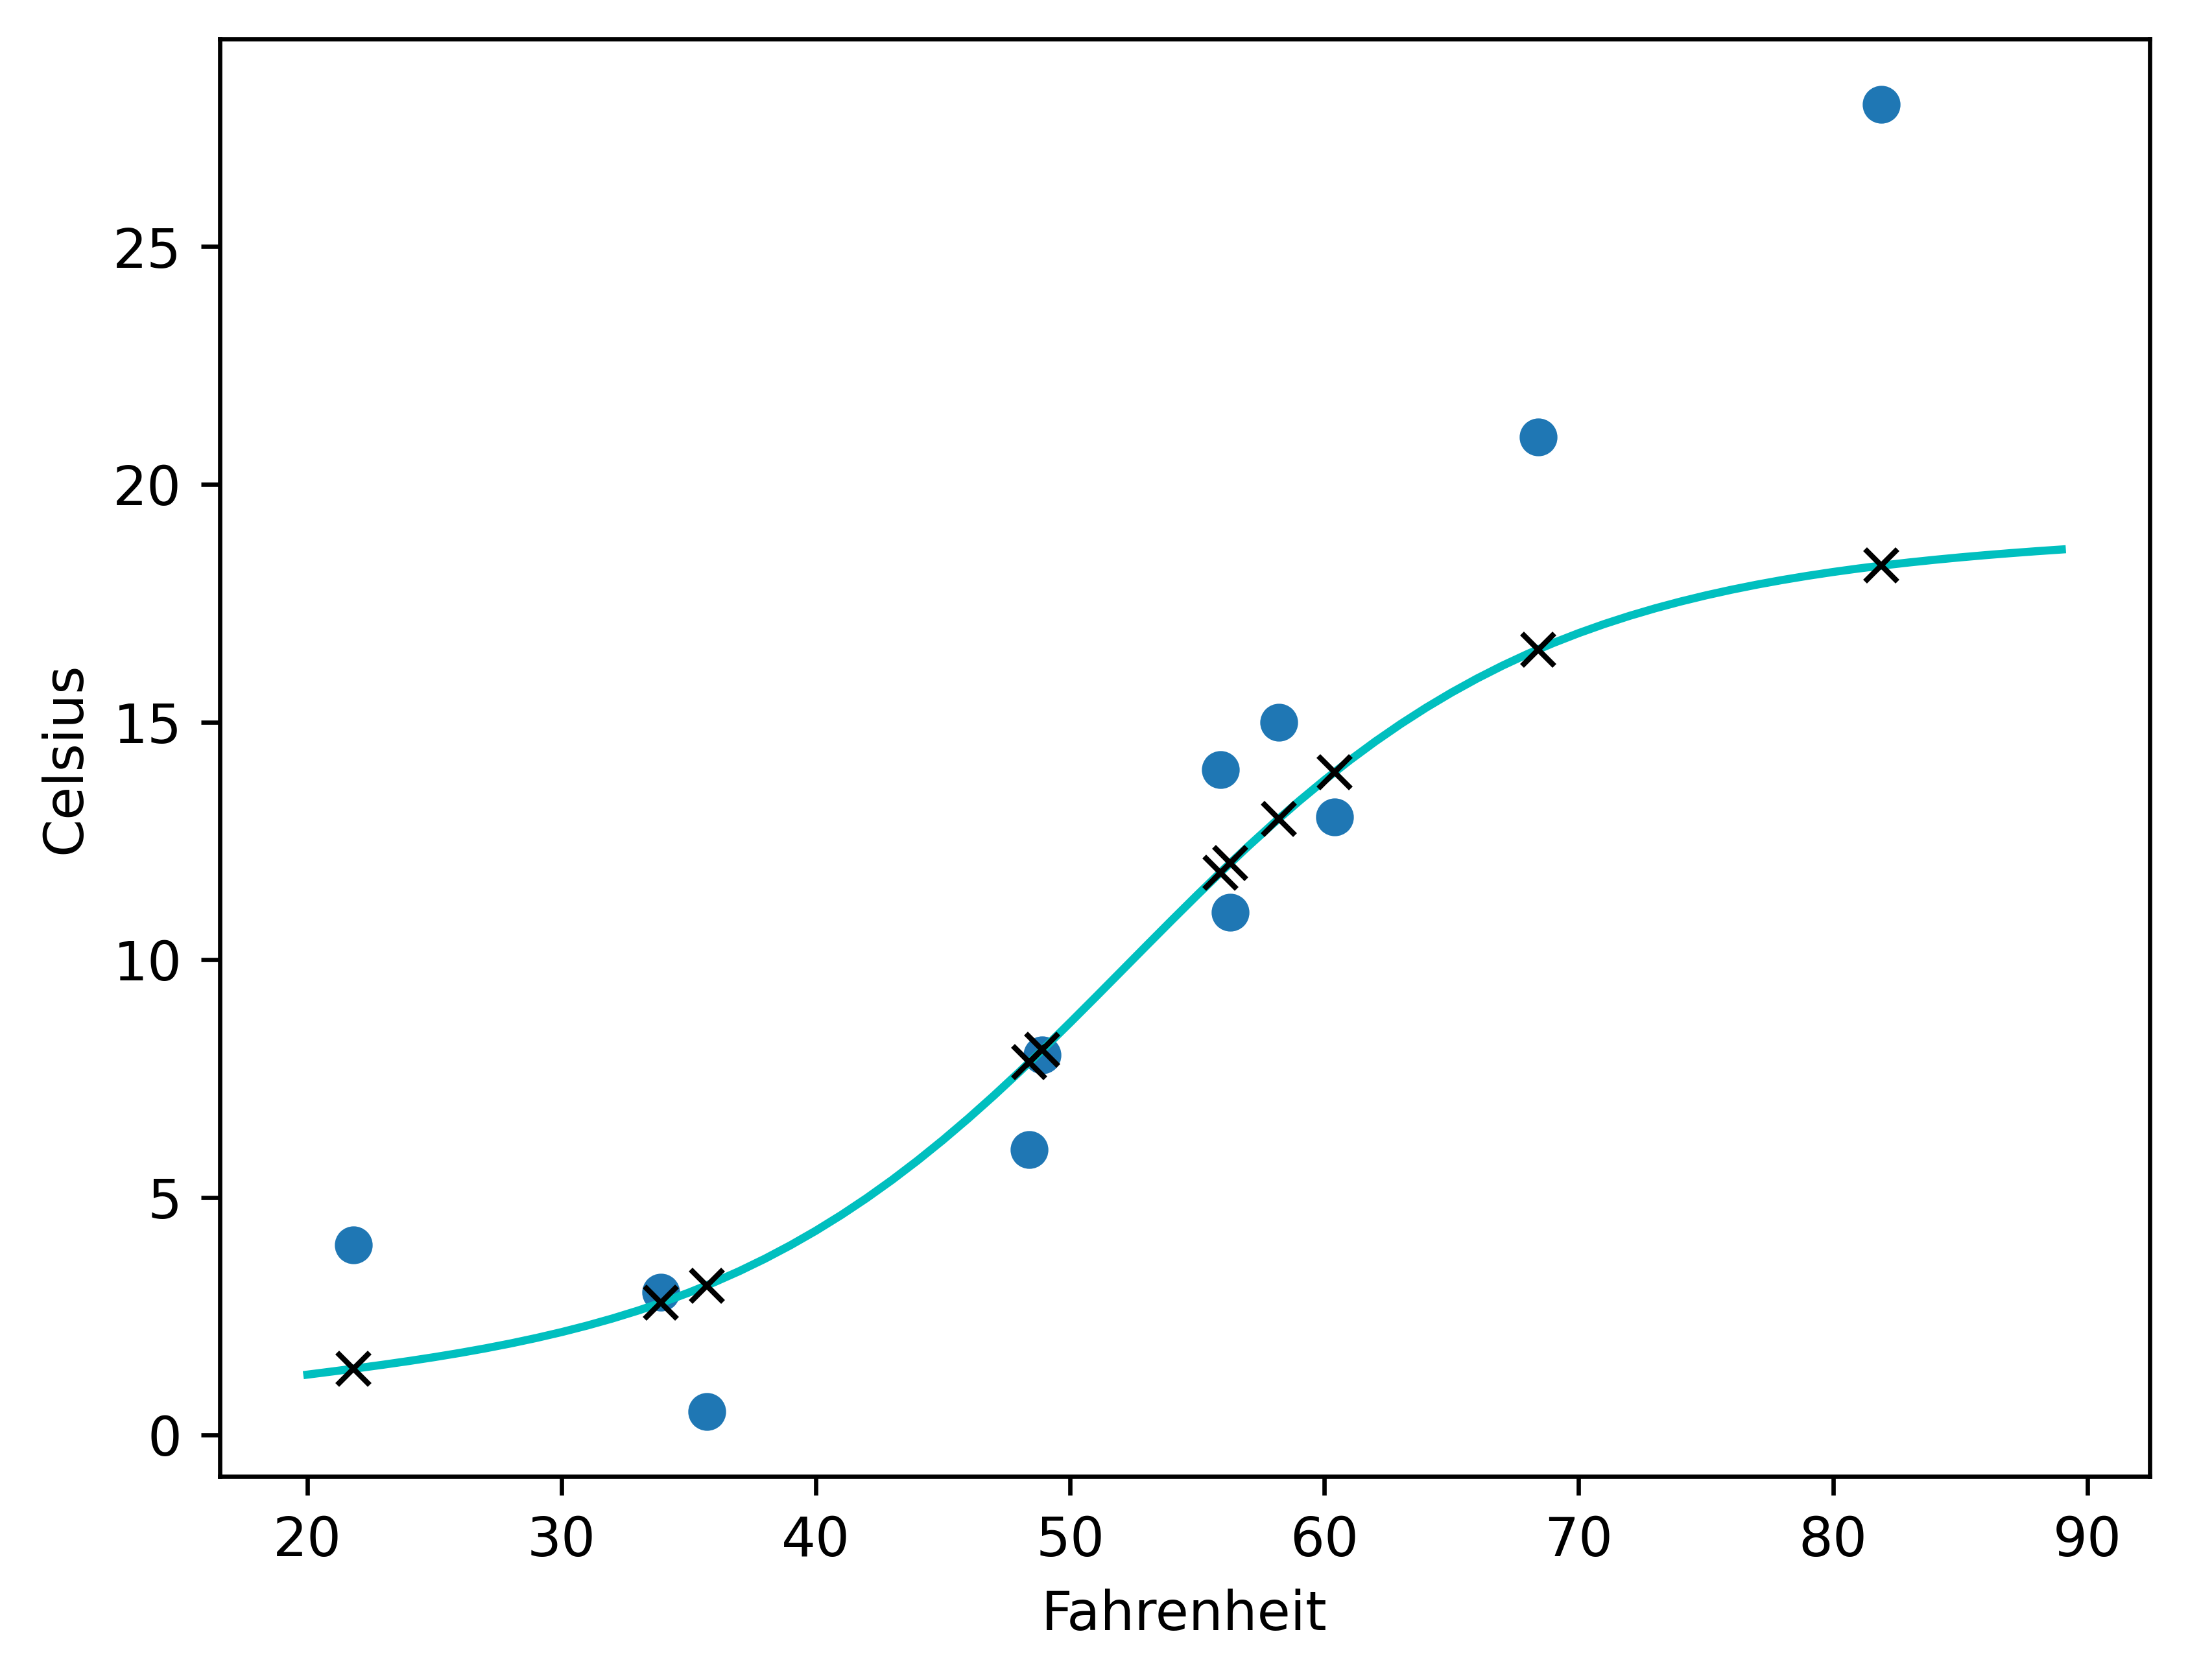

In [27]:
fig = plt.figure(dpi=600)
plt.xlabel('Fahrenheit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

### Упражнения

In [28]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, 4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1)
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

x_train = t_u[train_indices]
y_train = t_c[train_indices]

x_val = t_u[val_indices]
y_val = t_c[val_indices]

x_train = 0.1 * x_train
x_val = 0.1 * x_val

In [29]:
x_train

tensor([[2.1800],
        [3.3900],
        [4.8400],
        [4.8900],
        [6.0400],
        [5.8200],
        [5.6300],
        [5.5900],
        [3.5700]])

In [30]:
x_val

tensor([[6.8400],
        [8.1900]])

In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, x_train, x_val,
              y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        p_train = model(x_train)
        loss_train = loss_fn(p_train, y_train)
        
        p_val = model(x_val)
        loss_val = loss_fn(p_val, y_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f},'
                  f'Validation loss {loss_val.item():.4f}')

In [36]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1)),
    ('relu2', nn.ReLU()),
    ('output_linear', nn.Linear(8, 1))
]))

In [37]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
  (relu2): ReLU()
)

In [38]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

In [39]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    x_train = x_train,
    x_val = x_val,
    y_train = y_train,
    y_val = y_val
)

Epoch 1, Training loss 81.8449,Validation loss 578.3057
Epoch 500, Training loss 17.4974,Validation loss 236.8540
Epoch 1000, Training loss 9.1718,Validation loss 159.6654
Epoch 1500, Training loss 6.3905,Validation loss 116.1411
Epoch 2000, Training loss 5.3263,Validation loss 93.5304
Epoch 2500, Training loss 4.6502,Validation loss 80.2506
Epoch 3000, Training loss 4.1426,Validation loss 71.7704
Epoch 3500, Training loss 3.7479,Validation loss 66.1334
Epoch 4000, Training loss 3.4432,Validation loss 62.6173
Epoch 4500, Training loss 3.2050,Validation loss 61.0089
Epoch 5000, Training loss 3.0132,Validation loss 61.1742


In [85]:
wine_path = '/Users/alexfil/Desktop/PyTorch/data/winequality-white.csv'

In [ ]:
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)

In [86]:
wineq = torch.from_numpy(wineq_numpy)

In [87]:
data = wineq[:, :-1]
data[:-1], data.shape

(tensor([[ 7.0000,  0.2700,  ...,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  ...,  0.4900,  9.5000],
         ...,
         [ 6.5000,  0.2400,  ...,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  ...,  0.3800, 12.8000]]),
 torch.Size([4898, 11]))

In [88]:
target = wineq[:, -1].unsqueeze(1)
target,  target.shape

(tensor([[6.],
         [6.],
         ...,
         [7.],
         [6.]]),
 torch.Size([4898, 1]))

In [89]:
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

In [90]:
n_samples, n_val

(4898, 979)

In [91]:
data_mean = torch.mean(data, dim=0)

In [92]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04,
        2.8924e+02, 1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02,
        1.5144e+00])

In [93]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized, data_normalized.shape

(tensor([[ 1.7208e-01, -8.1761e-02,  ..., -3.4915e-01, -1.3930e+00],
         [-6.5743e-01,  2.1587e-01,  ...,  1.3422e-03, -8.2419e-01],
         ...,
         [-1.6054e+00,  1.1666e-01,  ..., -9.6251e-01,  1.8574e+00],
         [-1.0129e+00, -6.7703e-01,  ..., -1.4882e+00,  1.0448e+00]]),
 torch.Size([4898, 11]))

In [94]:
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

In [95]:
target_train = target[train_indices]
data_train = data_normalized[train_indices]

target_val = target[val_indices]
data_val = data_normalized[val_indices]

In [96]:
target_train.shape, data_train.shape

(torch.Size([3919, 1]), torch.Size([3919, 11]))

In [97]:
target_val.shape, data_val.shape

(torch.Size([979, 1]), torch.Size([979, 11]))

In [100]:
seq_model_wine = nn.Sequential(
    nn.Linear(11,100),
    nn.ReLU(),
    nn.Linear(100,50),
    nn.ReLU(),
    nn.Linear(50,25),
    nn.ReLU(),
    nn.Linear(25,1)
)
optimizer = optim.SGD(seq_model_wine.parameters(), lr=1e-3)

In [101]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model_wine,
    loss_fn = nn.MSELoss(),
    x_train = data_train,
    x_val = data_val,
    y_train = target_train,
    y_val = target_val
)

Epoch 1, Training loss 36.3378,Validation loss 35.9244
Epoch 500, Training loss 0.9188,Validation loss 0.8986
Epoch 1000, Training loss 0.7077,Validation loss 0.6971
Epoch 1500, Training loss 0.6121,Validation loss 0.6094
Epoch 2000, Training loss 0.5628,Validation loss 0.5669
Epoch 2500, Training loss 0.5369,Validation loss 0.5465
Epoch 3000, Training loss 0.5218,Validation loss 0.5356
Epoch 3500, Training loss 0.5117,Validation loss 0.5287
Epoch 4000, Training loss 0.5044,Validation loss 0.5239
Epoch 4500, Training loss 0.4987,Validation loss 0.5203
Epoch 5000, Training loss 0.4940,Validation loss 0.5175


In [60]:
pred = seq_model_wine(data_val)

In [62]:
pred[:5]

tensor([[6.3025],
        [5.5913],
        [5.4439],
        [5.6378],
        [6.2888]], grad_fn=<SliceBackward0>)